In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_absolute_percentage_error, precision_recall_curve
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_recall_curve


# Загрузка данных


Скачать датасет можно здесь : https://www.kaggle.com/datasets/laotse/credit-risk-dataset .

In [2]:
data = pd.read_csv('credit_risk_dataset.csv')
data

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


# EDA и предобработка признаков

In [3]:
y = data['loan_status']
X = data.drop('loan_status', axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_percent_income         32581 non-null  float64
 9   cb_person_default_on_file   32581 non-null  object 
 10  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 2.7+ MB


In [4]:
# One-Hot кодируем категориальные признаки
cat = X.select_dtypes('object').columns
X_t = pd.concat([X.drop(cat, axis=1), pd.get_dummies(X[cat])], axis=1)
X_t['person_emp_length']= X_t['person_emp_length'].fillna(X_t['person_emp_length'].median())
X_t['loan_int_rate']= X_t['loan_int_rate'].fillna(X_t['loan_int_rate'].median())

In [6]:
x_train, x_test, y_train, y_test = train_test_split(X_t, y, test_size=0.1)

# Создание модели

In [7]:
model = make_pipeline(StandardScaler(), CatBoostClassifier(verbose=0))

In [8]:
model.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x00000261F9A4AB50>)])

In [15]:
print("ACCURACY на тесте =", accuracy_score(y_test, model.predict(x_test)))
print("AUC_ROC на тесте =", roc_auc_score(y_test, model.predict(x_test)))


ACCURACY на тесте = 0.9377109542804541
AUC_ROC на тесте = 0.8618656463403181


In [16]:
y_pred = model.predict_proba(x_test)[:,1]
y_pred

array([0.0261391 , 0.03440601, 0.0447783 , ..., 0.08414135, 0.10394315,
       0.0024098 ])

In [17]:
precision, recall, thresholds = precision_recall_curve(y_test,y_pred)

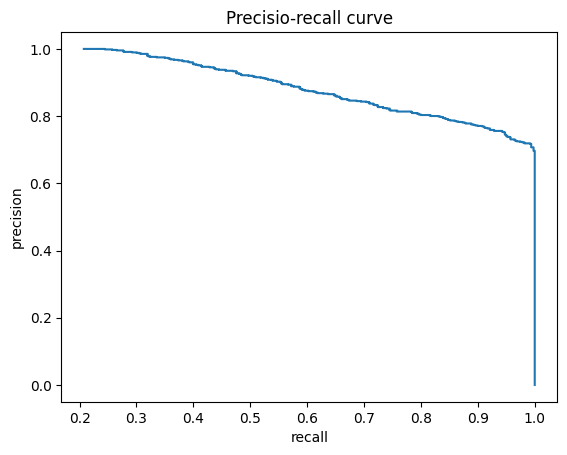

In [28]:
plt.plot(precision, recall, label = 'Precisio-recall curve')
plt.title('Precisio-recall curve')
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

# Подбор порогов

С помощью функций ниже можно максимизировать одну метрику, удерживая вторую не ниже заданного значения.

In [29]:
# для неизменного precision
def predict_pr(x_test, pr):
    id = np.searchsorted(sorted(precision), pr)
    y_pred = model.predict_proba(x_test)[:,1]
    y_pred_i = (y_pred >= thresholds[id]).astype(int)
    print("Precision=",precision_score(y_test, y_pred_i), '\n', "Recall=", recall_score(y_test, y_pred_i))
    return(y_pred_i)
    

In [30]:
pred_p = predict_pr(x_test, 0.95)


Precision= 0.9507575757575758 
 Recall= 0.742603550295858


In [31]:
# для неизменного recall

def predict_rec(x_test, rec):
    id = len(recall)-np.searchsorted(sorted(recall), rec, side='left')-1
    y_pred = model.predict_proba(x_test)[:,1]
    y_pred_i = (y_pred >= thresholds[id]).astype(int)
    print("Precision=",precision_score(y_test, y_pred_i), '\n', "Recall=", recall_score(y_test, y_pred_i))
    return(y_pred_i)

In [33]:
pred_r = predict_rec(x_test, 0.90)

Precision= 0.5546448087431693 
 Recall= 0.900887573964497
